In [1]:
xfile = 'F:\workspace\j6stock\XOpenHighLowCloseVol_tp10_cl10.txt'
lstm_size = 256         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 1024       # Batch size
learning_rate = 0.01  #0.0001  # Learning rate (default is 0.001)
epochs = 20

# Fixed
#amount_of_features_cvs = 5 # cvs with prefix with feature column
#n_channels = amount_of_features
seq_len = lstm_size
y_column = 6

In [2]:
import tensorflow as tf
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import os
from keras import backend as K

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\lai\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )

    df['change'] = df['open'] - df['close']
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [4]:
df = get_stock_data( ma=[50, 100, 200])
amount_of_features = len(df.columns)-1

In [5]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['close'], color='red', label='Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['change'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

         open      high       low     close    change      50ma     100ma  \
199  0.358586  0.355870  0.358374  0.357085  0.410872  0.351429  0.351070   
200  0.357245  0.354622  0.357608  0.356606  0.399494  0.351433  0.351063   
201  0.356623  0.354862  0.357799  0.356893  0.387484  0.351445  0.351060   
202  0.357054  0.354478  0.358422  0.357133  0.390013  0.351502  0.351082   
203  0.357293  0.355774  0.358709  0.358138  0.379899  0.351587  0.351141   

        200ma  y_result  
199  0.346428         0  
200  0.346426         0  
201  0.346424         0  
202  0.346433         0  
203  0.346448         0  


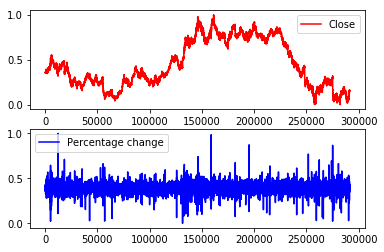

In [6]:
plot_stock(df)

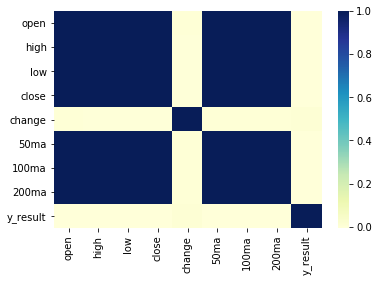

In [7]:
corr = df.corr()
ax = sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [8]:
def load_data(stock, seq_len):
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    x_result = []
    y_result = []
    for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
        x_result.append(data[index-seq_len: index,:-1]) # index : index + 22days
        y_result.append(data[index ,amount_of_features]);

    #print('---', data[0])
    #print('---', x_result[0])
    #print('---', y_result[0])
    x_result = np.array(x_result)
    y_result = np.array(y_result)
    row = round(0.6 * y_result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * x_result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * y_result.shape[0]))
     
    X_train = x_result[:int(row), :] # 90% date
    y_train = y_result[:int(row)] # 90% date
        

    X_test = x_result[int(row):, :]
    y_test = y_result[int(row):]
    # filter for 1 and -1 for validation only
    X_test = X_test[y_test[:]!=0,:]
    y_test = y_test[y_test[:]!=0]
    #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))
    
    return [X_train, y_train, X_test, y_test]

In [9]:
lb = preprocessing.LabelBinarizer()
lb.fit([1, 0, -1])

X_tr, lab_tr, X_vld, lab_vld = load_data(df, seq_len)
y_tr = lb.transform(lab_tr)
y_vld = lb.transform(lab_vld)
print(X_tr.shape, lab_tr.shape, X_vld.shape, lab_vld.shape)
print(amount_of_features)

Amount of features = 8
Amount of training data = 261796.5
Amount of testing data = 29088.5
(174531, 256, 8) (174531,) (70572, 256, 8) (70572,)
8


In [10]:
def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

In [11]:
graph = tf.Graph()
n_channels = amount_of_features
n_classes = lb.transform([1]).shape[1]
# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [12]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass, cost function and optimizer:

In [13]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [ ]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [ ]:
interation_compute_val = 1
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%interation_compute_val == 50):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

Epoch: 0/20 Iteration: 45 Train loss: 1.241376 Train acc: 0.278320
Epoch: 0/20 Iteration: 50 Train loss: 1.241789 Train acc: 0.341797
Epoch: 0/20 Iteration: 55 Train loss: 1.145764 Train acc: 0.329102
Epoch: 0/20 Iteration: 60 Train loss: 1.179893 Train acc: 0.285156
Epoch: 0/20 Iteration: 65 Train loss: 1.076938 Train acc: 0.490234
Epoch: 0/20 Iteration: 70 Train loss: 0.976970 Train acc: 0.613281
Epoch: 0/20 Iteration: 75 Train loss: 1.197176 Train acc: 0.375977
Epoch: 0/20 Iteration: 80 Train loss: 1.131732 Train acc: 0.253906
Epoch: 0/20 Iteration: 85 Train loss: 1.109090 Train acc: 0.415039
Epoch: 0/20 Iteration: 90 Train loss: 1.313343 Train acc: 0.195312
Epoch: 0/20 Iteration: 95 Train loss: 1.148013 Train acc: 0.339844
Epoch: 0/20 Iteration: 100 Train loss: 0.941742 Train acc: 0.656250
Epoch: 0/20 Iteration: 105 Train loss: 1.249629 Train acc: 0.347656
Epoch: 0/20 Iteration: 110 Train loss: 1.096401 Train acc: 0.471680
Epoch: 0/20 Iteration: 115 Train loss: 0.903970 Train acc: 

Epoch: 3/20 Iteration: 650 Train loss: 1.153425 Train acc: 0.221680
Epoch: 3/20 Iteration: 655 Train loss: 1.153649 Train acc: 0.235352
Epoch: 3/20 Iteration: 660 Train loss: 1.141642 Train acc: 0.177734
Epoch: 3/20 Iteration: 665 Train loss: 1.121958 Train acc: 0.166016
Epoch: 3/20 Iteration: 670 Train loss: 1.105287 Train acc: 0.239258
Epoch: 3/20 Iteration: 675 Train loss: 1.105782 Train acc: 0.302734
Epoch: 3/20 Iteration: 680 Train loss: 1.130661 Train acc: 0.148438
Epoch: 4/20 Iteration: 685 Train loss: 1.083830 Train acc: 0.466797
Epoch: 4/20 Iteration: 690 Train loss: 1.124865 Train acc: 0.287109
Epoch: 4/20 Iteration: 695 Train loss: 1.086262 Train acc: 0.499023
Epoch: 4/20 Iteration: 700 Train loss: 1.111584 Train acc: 0.379883
Epoch: 4/20 Iteration: 705 Train loss: 1.093029 Train acc: 0.390625
Epoch: 4/20 Iteration: 710 Train loss: 1.099370 Train acc: 0.375977
Epoch: 4/20 Iteration: 715 Train loss: 1.112114 Train acc: 0.163086
Epoch: 4/20 Iteration: 720 Train loss: 1.094659 

Epoch: 7/20 Iteration: 1250 Train loss: 1.144162 Train acc: 0.283203
Epoch: 7/20 Iteration: 1255 Train loss: 1.055923 Train acc: 0.489258
Epoch: 7/20 Iteration: 1260 Train loss: 0.997513 Train acc: 0.615234
Epoch: 7/20 Iteration: 1265 Train loss: 1.107585 Train acc: 0.380859
Epoch: 7/20 Iteration: 1270 Train loss: 0.995200 Train acc: 0.597656
Epoch: 7/20 Iteration: 1275 Train loss: 1.089549 Train acc: 0.415039
Epoch: 7/20 Iteration: 1280 Train loss: 1.191042 Train acc: 0.195312
Epoch: 7/20 Iteration: 1285 Train loss: 1.094504 Train acc: 0.415039
Epoch: 7/20 Iteration: 1290 Train loss: 0.992754 Train acc: 0.668945
Epoch: 7/20 Iteration: 1295 Train loss: 1.112305 Train acc: 0.347656
Epoch: 7/20 Iteration: 1300 Train loss: 1.050115 Train acc: 0.497070
Epoch: 7/20 Iteration: 1305 Train loss: 0.966067 Train acc: 0.659180
Epoch: 7/20 Iteration: 1310 Train loss: 1.133346 Train acc: 0.369141
Epoch: 7/20 Iteration: 1315 Train loss: 1.021524 Train acc: 0.567383
Epoch: 7/20 Iteration: 1320 Train 

Epoch: 10/20 Iteration: 1845 Train loss: 1.118474 Train acc: 0.287109
Epoch: 10/20 Iteration: 1850 Train loss: 1.088503 Train acc: 0.287109
Epoch: 10/20 Iteration: 1855 Train loss: 1.072902 Train acc: 0.404297
Epoch: 10/20 Iteration: 1860 Train loss: 1.174472 Train acc: 0.239258
Epoch: 10/20 Iteration: 1865 Train loss: 1.075049 Train acc: 0.302734
Epoch: 10/20 Iteration: 1870 Train loss: 1.277671 Train acc: 0.148438
Epoch: 11/20 Iteration: 1875 Train loss: 1.088580 Train acc: 0.415039
Epoch: 11/20 Iteration: 1880 Train loss: 1.195668 Train acc: 0.137695
Epoch: 11/20 Iteration: 1885 Train loss: 1.094745 Train acc: 0.263672
Epoch: 11/20 Iteration: 1890 Train loss: 1.125194 Train acc: 0.309570
Epoch: 11/20 Iteration: 1895 Train loss: 1.097001 Train acc: 0.315430
Epoch: 11/20 Iteration: 1900 Train loss: 1.098747 Train acc: 0.327148
Epoch: 11/20 Iteration: 1905 Train loss: 1.061927 Train acc: 0.680664
Epoch: 11/20 Iteration: 1910 Train loss: 1.064271 Train acc: 0.491211
Epoch: 11/20 Iterati

Epoch: 14/20 Iteration: 2435 Train loss: 1.080497 Train acc: 0.435547
Epoch: 14/20 Iteration: 2440 Train loss: 1.151029 Train acc: 0.283203
Epoch: 14/20 Iteration: 2445 Train loss: 1.053421 Train acc: 0.489258
Epoch: 14/20 Iteration: 2450 Train loss: 0.989484 Train acc: 0.615234
Epoch: 14/20 Iteration: 2455 Train loss: 1.115650 Train acc: 0.380859
Epoch: 14/20 Iteration: 2460 Train loss: 0.991101 Train acc: 0.597656
Epoch: 14/20 Iteration: 2465 Train loss: 1.086734 Train acc: 0.415039
Epoch: 14/20 Iteration: 2470 Train loss: 1.183999 Train acc: 0.195312
Epoch: 14/20 Iteration: 2475 Train loss: 1.090067 Train acc: 0.415039
Epoch: 14/20 Iteration: 2480 Train loss: 0.987908 Train acc: 0.668945
Epoch: 14/20 Iteration: 2485 Train loss: 1.112925 Train acc: 0.347656
Epoch: 14/20 Iteration: 2490 Train loss: 1.050908 Train acc: 0.497070
Epoch: 14/20 Iteration: 2495 Train loss: 0.963440 Train acc: 0.659180
Epoch: 14/20 Iteration: 2500 Train loss: 1.129838 Train acc: 0.369141
Epoch: 14/20 Iterati

Epoch: 17/20 Iteration: 3025 Train loss: 1.265512 Train acc: 0.055664
Epoch: 17/20 Iteration: 3030 Train loss: 1.117991 Train acc: 0.221680
Epoch: 17/20 Iteration: 3035 Train loss: 1.127013 Train acc: 0.262695
Epoch: 17/20 Iteration: 3040 Train loss: 1.098095 Train acc: 0.273438
Epoch: 17/20 Iteration: 3045 Train loss: 1.073749 Train acc: 0.288086
Epoch: 17/20 Iteration: 3050 Train loss: 1.174206 Train acc: 0.239258
Epoch: 17/20 Iteration: 3055 Train loss: 1.079918 Train acc: 0.302734
Epoch: 17/20 Iteration: 3060 Train loss: 1.265016 Train acc: 0.148438
Epoch: 18/20 Iteration: 3065 Train loss: 1.081918 Train acc: 0.381836
Epoch: 18/20 Iteration: 3070 Train loss: 1.195126 Train acc: 0.220703
Epoch: 18/20 Iteration: 3075 Train loss: 1.092634 Train acc: 0.266602
Epoch: 18/20 Iteration: 3080 Train loss: 1.126599 Train acc: 0.318359
Epoch: 18/20 Iteration: 3085 Train loss: 1.100225 Train acc: 0.284180
Epoch: 18/20 Iteration: 3090 Train loss: 1.101479 Train acc: 0.302734
Epoch: 18/20 Iterati

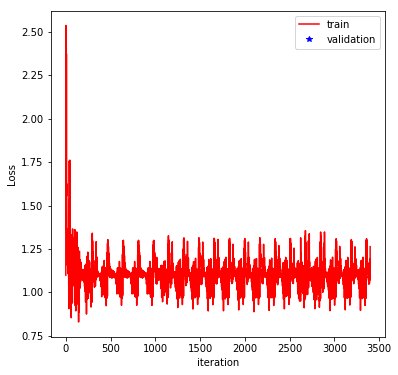

In [ ]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % interation_compute_val == 50], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

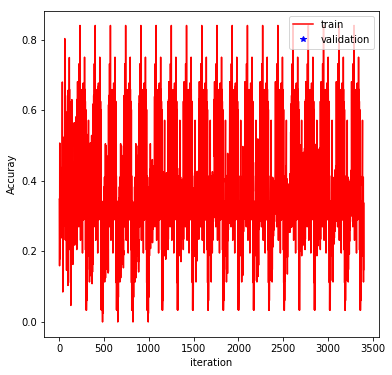

In [ ]:

# Plot Accuracies# Plot A 
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % interation_compute_val == 50], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Evaluate on test set

In [ ]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    print(y_vld.shape)
    for x_t, y_t in get_batches(X_vld, y_vld, batch_size):        
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        print(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints\har-lstm.ckpt
(70572, 3)
0.554688
0.453125
0.694336
0.516602
0.333984
0.410156
0.695313
0.463867
0.334961
0.56543
0.34375
0.65625
0.458984
0.633789
0.749023
0.355469
0.396484
0.631836
0.454102
0.326172
0.482422
0.554688
0.631836
0.457031
0.532227
0.451172
0.538086
0.404297
0.352539
0.422852
0.50293
0.466797
0.316406
0.479492
0.458008
0.514648
0.494141
0.294922
0.416016
0.646484
0.47168
0.551758
0.402344
0.389648
0.429688
0.633789
0.265625
0.541992
0.579102
0.40625
0.526367
0.435547
0.648438
0.583008
0.415039
0.524414
0.40625
0.657227
0.293945
0.381836
0.508789
0.628906
0.408203
0.683594
0.505859
0.385742
0.300781
0.527344
Test accuracy: 0.484389


In [ ]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  10],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a.max(axis=1) >= 10])


[[ 0  1  2  0  4  5  6  7  8 10]
 [ 0 11  0 13  0 15  0 17 18  0]]


In [ ]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a[:,2]!=0])

[[0 1 2 0 4 5 6 7 8 9]]


In [ ]:
print(ytest[:]!=0)
Xtest = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0],
             [ 0, 11,  0, 13,  0, 15,  0, 11, 1,  1]])
ytest = np.array([ 0,  1,  1])
Xtest = Xtest[ytest[:]!=0,:]
ytest = ytest[ytest[:]!=0]
print(Xtest)
print(ytest)

NameError: name 'ytest' is not defined